# Designing multi-objective molecules with ScafVAE
## Step 1. Loading dependencies
P.S. To use your own trained model, please replace files ("unique_xxx.csv", "scaf_xxx.npz" and "ScafVAE.chk") in ScafVAE_ROOT/params/ with your trained files as described in `demo_pretraining.ipynb` before loading dependencies.

In [1]:
from ScafVAE.app.app_utils import *

## Step 2. Training surrogate models for properties of interest
In this demo, we aim to generate dual-target drug candidates inhibit EGFR and HER2, which act synergistically in preclinical experiments (Konecny, Gottfried E., et al. Cancer research 66.3 (2006): 1630-1639.)

In [2]:
df_EGFR, df_HER2 = get_demo_properties(max_num=2000, name='binding')  # get inhibition data for two target proteins

df_EGFR  # 1 for active binders

,idx,smi,label
23840,23889,COc1ccccc1N1CCN(CCCN2C(=O)C3Nc4ccccc4C3N(C)C2=...,0
22747,22788,CC(=O)O.CC(C)c1ccc(C2CCN(CCCCNC(=O)c3ccc(NC(=O...,0
19438,19456,CC(C)C(c1cccc(NS(=O)(=O)c2ccc(F)cc2)c1)c1c(O)c...,0
17877,17878,CC[C@@H](C)Oc1cc2ncnc(Nc3ccc(Cl)c(Cl)c3F)c2cc1...,1
4246,4246,CCN1Cc2ccc(cc2C1)[C@H](Nc1cc(Cl)c2ncc(C#N)c(Nc...,1
...,...,...,...
24041,24090,NC(=S)N1N=C(c2ccc(F)cc2)C[C@@H]1c1ccc(Cl)cc1,0
12939,12940,COc1cc(N(C)CCN(C)C)c(NC(=O)C=C)cc1Nc1ncnc(-c2c...,1
13402,13403,CC(C)Oc1cc(C2CCNCC2)c(C)cc1Nc1ncc(Cl)c(Nc2cccc...,0
21657,21687,O=C(Cc1ccccc1)NCC1(N2CCN(C(=O)[C@@H](Cc3ccc(Cl...,0


In [3]:
generation_path = './generation'  # path for saving data
device = 'cuda'  # device for DL model: cpu / cuda
tasks = [  # EGFR and HER2 
    {
        # task name
        'name': 'EGFR_inhibition',

        # input data (pandas DataFrame)
        # columns: idx (unique index or ID for each molecule) / smi (SMILES) / label (values of property)
        'data': df_EGFR,

        # task type: classification / regression
        'task_type': 'classification',

        # ML model for surrogate model, string or initialized model object of sklearn:
        # adaboost / SVM / KNN / MLP / RF or e.g., RandomForestClassifier() ...
        # If using a name string, the model is trained with a grid search
        # P.S. If the dataset is too small (<200), error may occur in grid search. Then you shall use your own initialized model object.
        'ML_model': 'RF',

        # property is need to be maximized or minimized: max / min
        'optimization_type': 'max',

        # pseudo weight for this property
        'pseudo_weight': 0.5,
    },
    {
        'name': 'HER2_inhibition',
        'data': df_HER2,
        'task_type': 'classification',
        'ML_model': 'RF',
        'optimization_type': 'max',
        'pseudo_weight': 0.5,
    },
]

#### Preparing data and training the surrogate models

In [4]:
base_model, surrogate_model = prepare_data_and_train(generation_path, tasks, device=device, n_jobs=32)

Loading ScafVAE parameters ...
Preparing EGFR_inhibition ...


Calculating EGFR_inhibition latent vectors: 100%|██████████| 63/63 [00:41<00:00,  1.50it/s]


EGFR_inhibition done.
Preparing HER2_inhibition ...


Calculating HER2_inhibition latent vectors: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


HER2_inhibition done.
Training surrogate model for EGFR_inhibition ...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Finished training - 30.0s
EGFR_inhibition done.
Training surrogate model for HER2_inhibition ...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Finished training - 23.9s
HER2_inhibition done.


#### Visualization
Plot the ROC curve to evaluate the accuracy

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ROC(name):
    model = surrogate_model[name]['automl']
    x_test = surrogate_model[name]['x_test']
    y_test = surrogate_model[name]['y_test']

    y_pred = model.predict(x_test)

    metric = 'ROC-AUC'  # ROC-AUC / Spearman
    score = AutoML.calc_metric(y_test, y_pred, metric)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

    sns.set_style('whitegrid')
    sns.set_context('talk')

    fig, ax = plt.subplots(1, 1, figsize=(8, 7))
    ax.plot(fpr, tpr, lw=2.0)
    ax.plot([0, 1], [0, 1], lw=2.0, linestyle='--', color='k')

    ax.set_ylabel(f'True positive rate')
    ax.set_xlabel(f'False positive rate')
    ax.set_title(f'{name} test set {metric}: {score:.3f}')
    fig.tight_layout()
    plt.show()

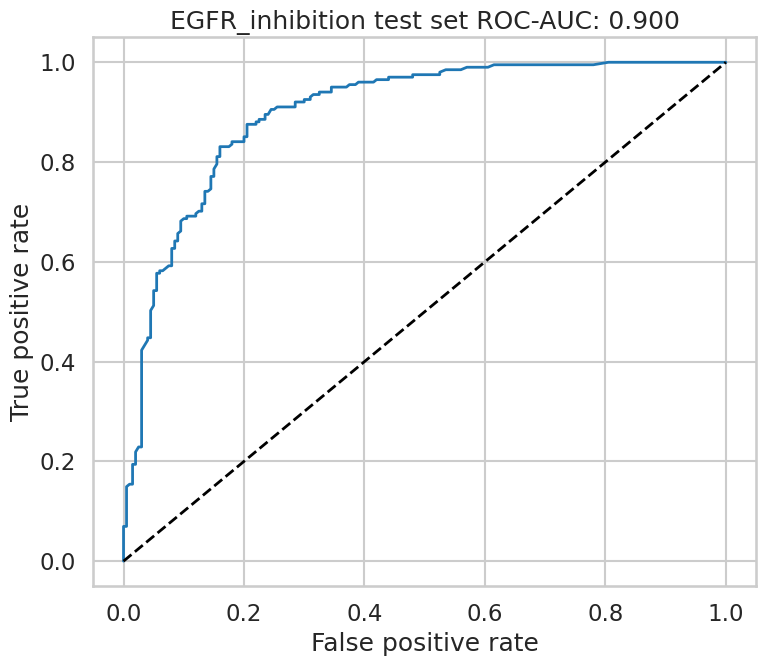

In [6]:
plot_ROC('EGFR_inhibition')

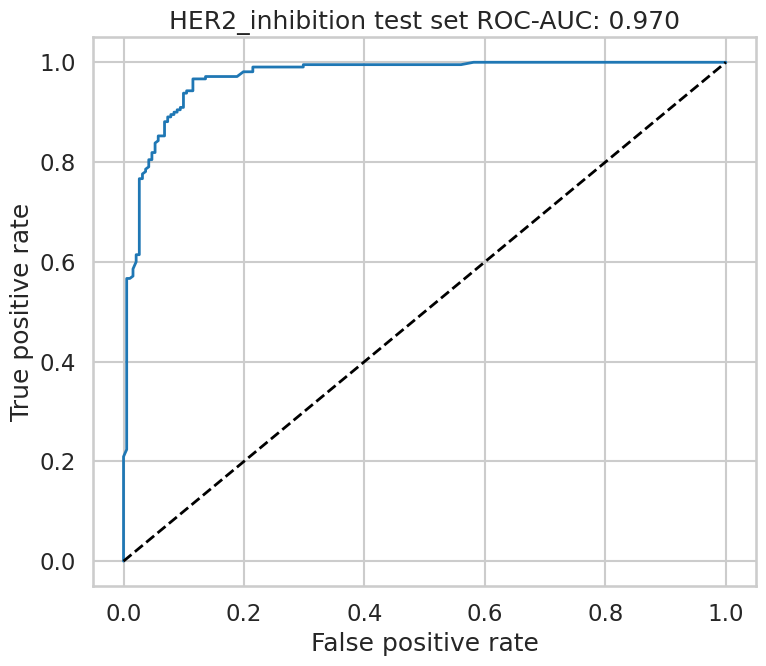

In [7]:
plot_ROC('HER2_inhibition')

## Step 3. Generating multi-objective molecules
Molecular generation by Bayesian optimization (BO)

In [10]:
df_output = generate_mol(
    10,  # number of generated molecules
    generation_path, tasks, base_model, surrogate_model,
    MAXGEN=200,  # max iteration for BO
    multi_cpu=False,  # using multiple CPUs, if the surrogate models are heavy.
    seed=0,
)
df_output

Generating molecules: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


,seed,smi,predicted EGFR_inhibition,predicted HER2_inhibition
0,0,Cc1cc(Nc2cc(OCC(=O)CCCl)ccc2F)c2ncc(OCC3(F)CCO...,1.0,1.0
1,1,C#Cc1cncc(Nc2c(NCOc3ccc4c(c3)C(F)(OCC3CCOC3)C=...,1.0,1.0
2,2,[H]C([H])=C([H])C([H])([H])N1C([H])([H])OC([H]...,1.0,1.0
3,3,CNC(=O)c1ccc(COc2cc3nnc(NCCC#Cn4cc(Nc5ncnc6ccc...,1.0,1.0
4,4,C=CN(c1cc(Cl)cc(Oc2cncc(CN(C)c3cc4c(cc3OC(=O)O...,1.0,1.0
5,5,O=CC=C(c1cc2c(OCCc3c(Nc4cc(F)ccc4Cl)oc4cnccc34...,1.0,1.0
6,6,CN(Cc1cc(COc2c(N)c3nccsc-3c2Cl)ccc1C(F)(F)F)c1...,1.0,1.0
7,7,O=C(COc1cc(F)cc2ncc(F)cc12)Nc1cnccc1NC(CC1CCOC...,1.0,1.0
8,8,Cc1cc(C(F)F)c2c(Nc3nc4c(cc3NC(=O)C=Cc3cc(Cl)cc...,1.0,1.0
9,9,O=C(C=Cc1cnco1)Nc1ccc(C#Cc2ccnc3c(Cl)cc(NC4C(F...,1.0,1.0


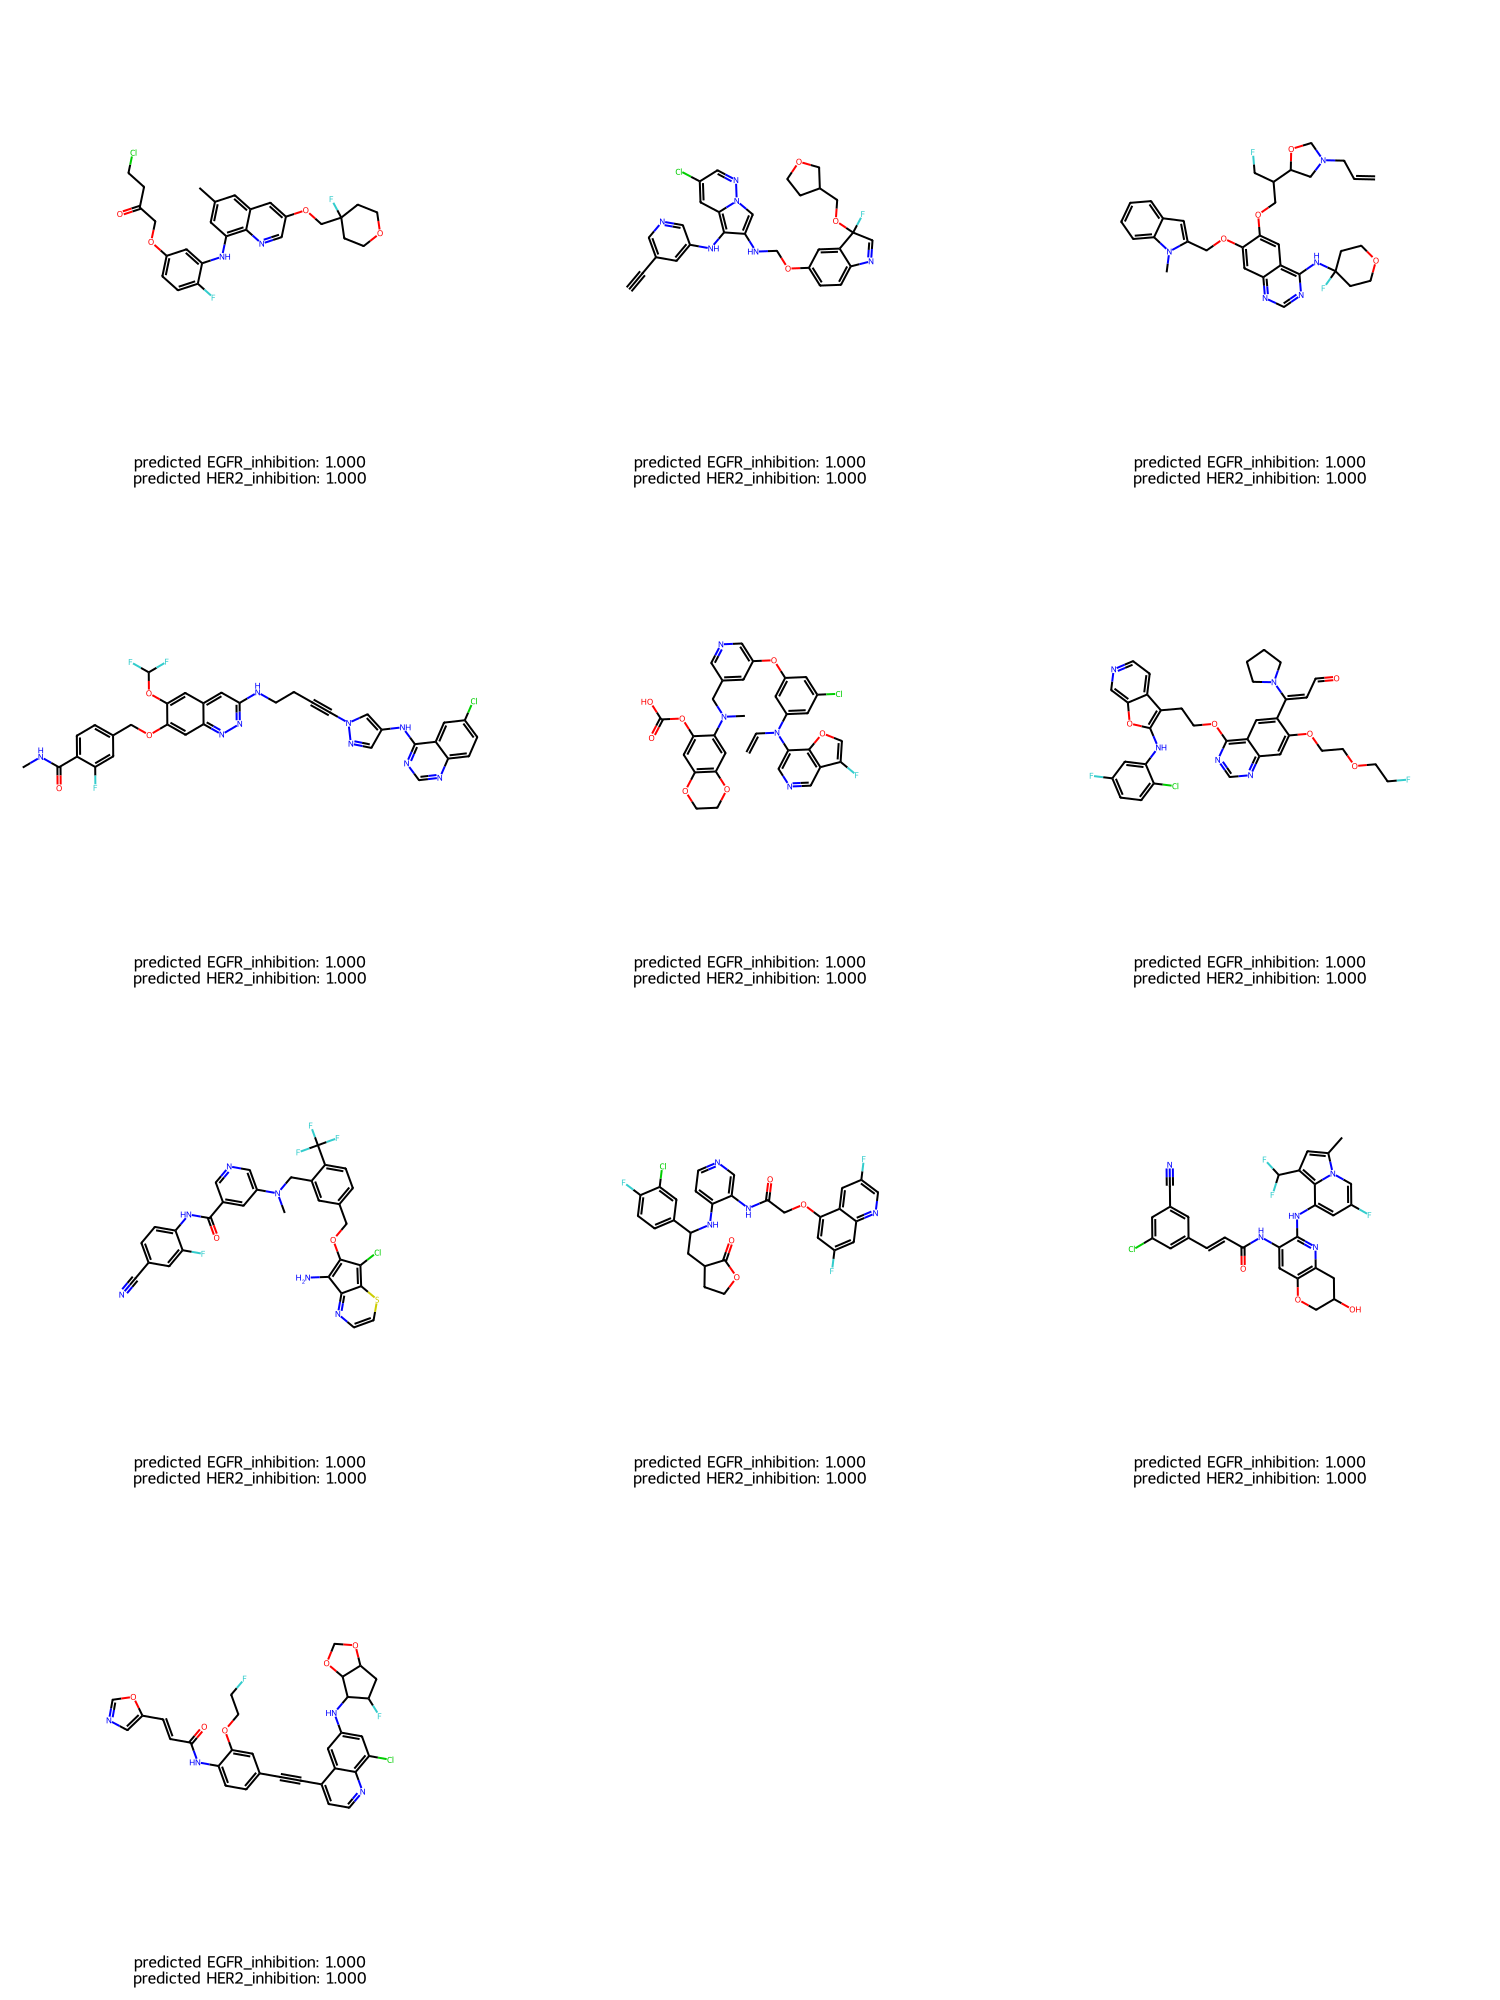

In [11]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smi) for smi in df_output['smi']],
    legends=[
        f"{'predicted ' + tasks[0]['name']}: {p1:.3f}\n{'predicted ' + tasks[1]['name']}: {p2:.3f}"
        for p1, p2 in zip(df_output['predicted ' + tasks[0]['name']], df_output['predicted ' + tasks[1]['name']])
    ],
    subImgSize=(500, 500),
)